<a href="https://colab.research.google.com/github/Suryarenuka/fmml2021/blob/main/Lab3_FMML2021620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try these questions for better understanding. You may not be able to solve all of them.

1.What is the best value for angle constraint and shear constraint you got?How much did the accuracy improve as compared to not using augmentations?

2.Can you increase the accuracy by increasing the number of augmentations from each sample?

3.Try implementing a few augmentations of your own and experimenting with them. A good reference is here.

4.Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

1.What is the best value for angle constraint and shear constraint you got?How much did the accuracy improve as compared to not using augmentations?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math
from skimage.util import random_noise
from skimage.filters import gaussian

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

# nearest neighbour function
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [4]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us augment the whole dataset and see if this improves the test accuracy

In [5]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6742


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [6]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.672
Accuracy after rotation augmentation constrained by  20  is  0.6708
Accuracy after rotation augmentation constrained by  30  is  0.6852
Accuracy after rotation augmentation constrained by  40  is  0.6808
Accuracy after rotation augmentation constrained by  50  is  0.6779
Accuracy after rotation augmentation constrained by  60  is  0.6728
Accuracy after rotation augmentation constrained by  70  is  0.6676
Accuracy after rotation augmentation constrained by  80  is  0.6504
Accuracy after rotation augmentation constrained by  90  is  0.6467


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

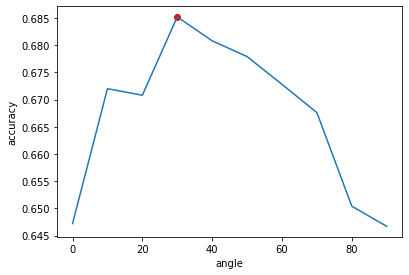

In [7]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Augmentation 2
Let us try one more augmentation: shear. Here is what this looks like:

In [8]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

In [9]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

In [10]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6198
Accuracy after shear augmentation constrained by  0.4  is  0.6289
Accuracy after shear augmentation constrained by  0.6  is  0.6444
Accuracy after shear augmentation constrained by  0.8  is  0.6556
Accuracy after shear augmentation constrained by  1.0  is  0.6561
Accuracy after shear augmentation constrained by  1.2  is  0.6275
Accuracy after shear augmentation constrained by  1.4  is  0.6244
Accuracy after shear augmentation constrained by  1.6  is  0.596
Accuracy after shear augmentation constrained by  1.8  is  0.6067
Accuracy after shear augmentation constrained by  2.0  is  0.6345


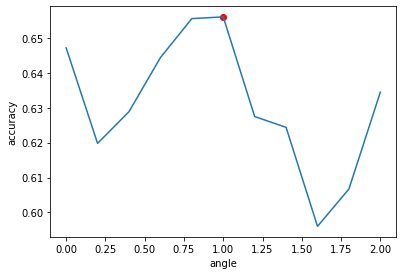

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

Best value for angle constraint =30 ----- accuracy=68.52%

Best value for shear constraint=1.0 ---- accuracy=65.61%

accuraccy before augmentations=64.72%

accuracy after augmentations= 67.42%

there is 2.7% improvement in accuracy.

2.Can you increase the accuracy by increasing the number of augmentations from each sample?

Let us try by increasing the number of augmentations. trying with different naugmentations 5,20,30,40...

In [12]:
# hyperparameters
angleconstraint = 60
naugmentations = 150

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6778


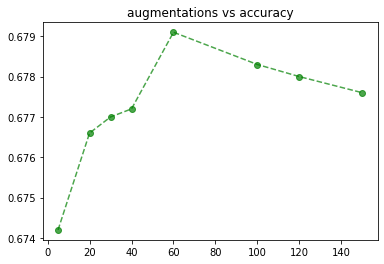

In [13]:
a=[5,20,30,40,60,100,120,150] # naugmentations
b=[0.6742,0.6766,0.677, 0.6772,0.6791,0.6783,0.678,0.6776] #accuracy

plt.plot(a,b,'o--', color='Green', alpha=0.7)
plt.title("augmentations vs accuracy")
plt.xlabel="naugmentations"
plt.ylabel="accuracy"
plt.show()

There is a fractional increase in accuracy as we increase the number of augmentations. But after a certain range there is a fall(downward face in the graph) in the accuracy if we keep on increasing the number of augmentations.

3.Try implementing a few augmentations of your own and experimenting with them.

Augmentation 1

Here I am adding noise to the dataset.

In [14]:
def add_noise(sample, sigma=0.155):

  #  return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional

  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
     nsample[ii] = random_noise(sample[ii], var=sigma**2)
 
  return np.squeeze(nsample) # take care if the input had only one sample.

#plt.imshow(noisyRandom)
#plt.title('Random Noise')
 # return np.squeeze(nsample) # take care if the input had only one sample.

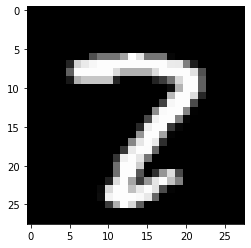

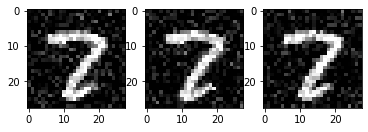

In [15]:
sample = train_X[10]
#angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(add_noise(sample, sigma=0.155), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(add_noise(sample, sigma=0.155), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(add_noise(sample, sigma=0.155), cmap='gray') # one more image from the same sample

In [16]:
# Let's augment whole dataset by adding noise.
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, add_noise(train_X, sigma=0.155))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after adding noise augmentation is ', Accuracy(test_y, testpred))

Accuracy after adding noise augmentation is  0.6468


Augmentation 2

Let's blurr the image.

Text(0.5, 1.0, 'Blurred Image')

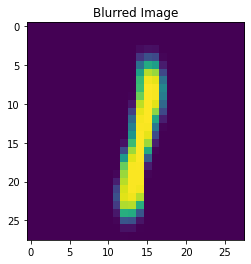

In [17]:
#blur the image
blurred = gaussian(train_X[1],sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')


In [18]:
def blurr_image(sample, sigma=1,multichannel=True):

  #  return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional

  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
     nsample[ii] = gaussian(sample[ii], sigma=1,multichannel=True)
 
  return np.squeeze(nsample) # take care if the input had only one sample.



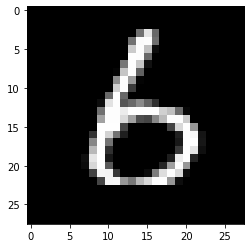

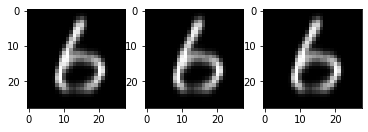

In [19]:
sample = train_X[4]

# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(blurr_image(sample, sigma=1), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(blurr_image(sample, sigma=1), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(blurr_image(sample, sigma=1), cmap='gray') # one more image from the same sample

In [20]:
# Let's augment whole dataset by adding noise.
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, blurr_image(train_X, sigma=1))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after blurring  augmentation is ', Accuracy(test_y, testpred))

Accuracy after blurring  augmentation is  0.6776


4.Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

augmenting by adding noise and blurring the image one after one

In [21]:
sigma = [0,1,2,3,4,5] # the values we want to test
var = [0,0.04,0.16,0.36,0.64,1] # the values we want to test
hyp =cartesian((sigma, var)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here
naugmentations=1
for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, add_noise(train_X, hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment
    augdata = np.concatenate((augdata, blurr_image(train_X,  hyp[ii][0]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation adding noise:',hyp[ii][0], 'blurring image',hyp[ii][1], ' is ', accuracies[ii], flush=True)


Accuracy after augmentation adding noise: 0 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 0 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 0 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 0 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 0 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 0 blurring image 1  is  0.6776
Accuracy after augmentation adding noise: 1 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 1 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 1 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 1 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 1 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 1 blurring image 1  is  0.6776
Accuracy after augmentation adding noise: 2 blurring image 0  is  0.6776
Accuracy after augmentation adding noise: 2 blurrin

implementing rotate and shear augmentations one after one.

In [23]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here
naugmentation
for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment
    augdata = np.concatenate((augdata, augShear(train_X,  hyp[ii][0]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

NameError: ignored

Let's try with smallets dataset Here I am training with 10 samples.

In [32]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here
naugmentations
for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment
    augdata = np.concatenate((augdata, augShear(train_X,  hyp[ii][0]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6472
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.664
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6831
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6805
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6669
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6817
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6637
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6197
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6601
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.667
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6806
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6579
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.6619
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6587
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6374
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.66

Let's try with smallets dataset Here I am training with 10 samples.

In [25]:
dataset=None
for i in range(10):
  if dataset is None:
    dataset=np.expand_dims(train_X[train_y==i][0],0)
  else:
    dataset=np.concatenate((dataset, np.expand_dims(train_X[train_y==i][0],0)))  
  labels=np.arange(10)  

In [26]:
testpred = NN(dataset, labels, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.4549


In [27]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here
naugmentations=5
for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = dataset # we include the original images also in the augmented dataset
  auglabel = labels
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(dataset, hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, labels))  # the labels don't change when we augment
    augdata = np.concatenate((augdata, augShear(dataset,  hyp[ii][0]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, labels))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.4549
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.4873
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.4962
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.4901
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.5001
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.4956
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.4941
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.4279
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.4654
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.4735
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.485
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.4952
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.4829
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.4892
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.4525
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.4